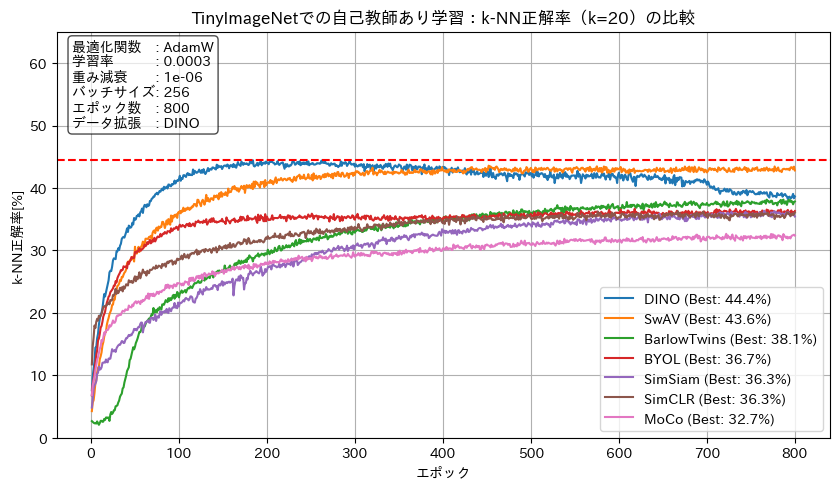

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob


def extract_scalar_arrays(scalar_events):
    wall_times, steps, values = [], [], []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)


def plot_scalar_values(
    paths_pattern, scalar_tag, title, xlabel, ylabel, ylim, hyperparameters
):
    fig, ax = plt.subplots(figsize=(10, 5))
    best_accuracy = 0  # 最高の k-NN 精度を保持する変数

    # パスと最高精度のディクショナリを作成
    ssl_accuracy_dict = {}

    for path in glob(paths_pattern):
        ssl = path.split("/")[-1]
        accumulator = EventAccumulator(f"{path}/DINO/{ssl}")
        accumulator.Reload()
        wall_times, steps, values = extract_scalar_arrays(
            accumulator.Scalars(scalar_tag)
        )

        # 最高精度を取得
        max_accuracy = np.max(values)
        ssl_accuracy_dict[ssl] = max_accuracy

    # 最高精度でディクショナリを降順にソート
    sorted_ssl_accuracy = sorted(
        ssl_accuracy_dict.items(), key=lambda x: x[1], reverse=True
    )

    # グラフと凡例を描画
    for ssl, max_accuracy in sorted_ssl_accuracy:
        path = [p for p in glob(paths_pattern) if ssl in p][0]  # パスを取得
        accumulator = EventAccumulator(f"{path}/DINO/{ssl}")
        accumulator.Reload()
        wall_times, steps, values = extract_scalar_arrays(
            accumulator.Scalars(scalar_tag)
        )

        # 最高の k-NN 精度を探す
        max_accuracy = np.max(values)
        if max_accuracy > best_accuracy:
            best_accuracy = max_accuracy

        ax.plot(steps, values, label=f"{ssl} (Best: {max_accuracy:.1f}%)")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(*ylim)
    ax.grid(True)

    # ハイパーパラメータ情報を左上に表示
    hyperparam_text = (
        f"最適化関数　: {hyperparameters['name']}\n"
        f"学習率　　　: {hyperparameters['args']['lr']}\n"
        f"重み減衰　　: {hyperparameters['args']['weight_decay']}\n"
        f"バッチサイズ: {hyperparameters['batch_size']}\n"
        f"エポック数　: {hyperparameters['max_epoch']}\n"
        f"データ拡張　: {hyperparameters['transforms']}"
    )
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.7)
    ax.text(
        0.02,
        0.98,
        hyperparam_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=bbox_props,
    )

    # レイアウト調整
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # 凡例を右下に配置
    ax.legend(loc="lower right")

    # 最高の k-NN 精度を横棒グラフで示す
    ax.axhline(y=best_accuracy, color="red", linestyle="--")

    plt.savefig("pre-train.svg")
    plt.show()


if __name__ == "__main__":
    batch_size = 256
    optim_setting = {
        "name": "AdamW",
        "args": {
            "lr": 3e-4 * (batch_size / 256),
            "weight_decay": 1e-6,
        },
    }
    max_epoch = 800
    transforms = "DINO"

    hyperparameters = {
        "name": optim_setting["name"],
        "args": optim_setting["args"],
        "batch_size": batch_size,
        "max_epoch": max_epoch,
        "transforms": transforms,
    }

    plot_scalar_values(
        "runs/pre-train/resnet18/*",
        scalar_tag="test_top1",
        title="TinyImageNetでの自己教師あり学習：k-NN正解率（k=20）の比較",
        xlabel="エポック",
        ylabel="k-NN正解率[%]",
        ylim=(0, 65),
        hyperparameters=hyperparameters,
    )